### MBD-EN OCT20 - IE School of Human Scienses & Technology
# Machine Learning II
### Group Assignment - Predicting Spanish Power Price
**Authors:** Group D - Kathleen Hess, Raquel Cabero, Ignacio Martinez, Pedro Santos, Isagani Trinidad, Julian Scholz

**Date:** 08/03/2021

We were tasked to implement a working solution for a Machine Learning problem. In more detail, we were provided with two real datasets for the Spanish Power Market and our task was to build a regression model predicting the day-ahead price of power in Spain given some forecast available before the daily auction.

One dataset (“power_market.csv”) was composed of 10 columns with data from 01/01/2017 to 31/08/2020 and the other dataset (“scoring.csv”) had 9 columns (target variable “price” not included) with data from 01/09/2020 to 31/01/2021.


# Importing libraries and custom functions

In [1]:
#Holy Trinity
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#Pipeline & Processing
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_transformer, make_column_selector, ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import datetime as dt

#Model
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.linear_model import Ridge , Lasso
from sklearn.model_selection import cross_val_score, TimeSeriesSplit

#Revision
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error , r2_score 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

#Visualization
import seaborn as sns
import ipywidgets as ipw
plt.style.use("seaborn-white")

import random
random.seed(10)

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def evaluate( test_features, test_labels):
    print('Root Mean squared error: %.2f'% mean_squared_error(test_features, test_labels, squared = False)) #setting to false returns RMSE
    # The coefficient of determination: 1 is perfect prediction
    print('Coefficient of determination: %.2f'%r2_score(test_features, test_labels))
    print('MAPE: %.2f'%  mean_absolute_percentage_error(test_features, test_labels))

def outlier(col, n):
    IQR = col.quantile(.75) - col.quantile(.25)
    upper = col.quantile(.75) + (n*IQR)
    lower = col.quantile(.25) - (n*IQR)
    print("Percent Outliers:", "{:.2%}".format( ( len(df[col > upper]) + len(df[col < lower]) ) / len(df) ) )
    print("Percent Low Outliers:", "{:.2%}".format( len(df[col < lower]) / len(df) ) )
    print("Percent High Outliers:", "{:.2%}".format( len(df[col > upper]) / len(df) ) )
    return lower, upper
    

# Load & QA Data

In [2]:
train = pd.read_csv("power_market.csv",parse_dates=['date'])
test = pd.read_csv("scoring.csv",parse_dates=['date'])

In [3]:
train.shape

(32135, 10)

In [4]:
train.head(525)

,fc_demand,fc_nuclear,import_FR,export_FR,fc_wind,fc_solar_pv,fc_solar_th,price,date,hour
0,24400.0,7117.2,3000.0,2600.0,1732.0,0.0,5.1,58.82,2017-01-01,0
1,23616.0,7117.2,3000.0,2650.0,1826.0,0.0,0.6,58.23,2017-01-01,1
2,21893.0,7117.2,3000.0,2650.0,1823.0,0.0,4.6,51.95,2017-01-01,2
3,20693.0,7117.2,3000.0,2650.0,1777.0,0.0,9.7,47.27,2017-01-01,3
4,19599.0,7117.2,3000.0,2650.0,1746.0,0.0,24.1,45.49,2017-01-01,4
...,...,...,...,...,...,...,...,...,...,...
520,28289.0,7117.2,3000.0,2400.0,6325.0,1144.9,892.4,62.52,2017-01-22,16
521,28304.0,7117.2,3000.0,2400.0,6240.0,439.5,738.0,67.33,2017-01-22,17
522,30552.0,7117.2,2800.0,2200.0,5942.0,75.2,382.1,85.38,2017-01-22,18
523,32483.0,7117.2,2800.0,2200.0,6185.0,0.0,110.0,92.12,2017-01-22,19


In [5]:
train.dtypes

fc_demand             float64
fc_nuclear            float64
import_FR             float64
export_FR             float64
fc_wind               float64
fc_solar_pv           float64
fc_solar_th           float64
price                 float64
date           datetime64[ns]
hour                    int64
dtype: object

In [6]:
train.describe()

,fc_demand,fc_nuclear,import_FR,export_FR,fc_wind,fc_solar_pv,fc_solar_th,price,hour
count,32135.000000,32135.000000,32122.000000,32122.000000,32135.000000,32135.000000,32135.000000,32135.000000,32135.000000
mean,28475.593527,6421.333431,2445.285163,2217.864703,5627.214688,1100.253546,601.186600,48.440119,11.500296
std,4686.675600,862.355391,623.215136,550.563300,3266.961919,1512.531532,681.584906,14.842233,6.922199
min,16372.000000,3672.800000,700.000000,200.000000,139.000000,0.000000,0.000000,0.030000,0.000000
25%,24605.500000,6071.900000,2100.000000,1900.000000,3083.000000,0.000000,31.600000,39.770000,6.000000
50%,28446.000000,7117.200000,2450.000000,2200.000000,4989.000000,107.800000,331.400000,49.880000,12.000000
75%,32124.000000,7117.200000,2900.000000,2600.000000,7610.500000,2099.350000,957.150000,58.250000,17.500000
max,41103.000000,7117.200000,3700.000000,3700.000000,17232.000000,7211.200000,2253.700000,101.990000,23.000000


# Feature Generation

Note that date & hour is seperate in the base file, but it might be interesting to understand how our variables are changing hour by hour, so we'll start by combining these two into one datetime field. The hour value needs to be transformed before it can be understood as a datetime value and combined with other datetime values. For %H to interpret the value correctly, we must code single digits as 01, 02, etc.

In [7]:
#formatting hour into correct format for %H and combining to date:
train["datetime"] = train["date"].astype("str")+" "+ train['hour'].apply('{0:0>2}'.format)
test["datetime"] = test["date"].astype("str")+" "+ test['hour'].apply('{0:0>2}'.format)

#parse new column as datetime:
train["datetime"] = pd.to_datetime(train["datetime"], format = '%Y/%m/%d %H')
test["datetime"] = pd.to_datetime(test["datetime"], format = '%Y/%m/%d %H')


train.head(2)

,fc_demand,fc_nuclear,import_FR,export_FR,fc_wind,fc_solar_pv,fc_solar_th,price,date,hour,datetime
0,24400.0,7117.2,3000.0,2600.0,1732.0,0.0,5.1,58.82,2017-01-01,0,2017-01-01 00:00:00
1,23616.0,7117.2,3000.0,2650.0,1826.0,0.0,0.6,58.23,2017-01-01,1,2017-01-01 01:00:00


**Next we'll generate features based off of our datetime string:**

In [8]:
train["year"] = train.datetime.dt.year
train["month"] = train.datetime.dt.month
train["day"] = train.datetime.dt.day
train["dayofweek"] = train.datetime.dt.dayofweek #to know working day or not if monday(1) -friday (5) yes + if holiday 
train["dayofyear"]= train.datetime.dt.dayofyear

test["year"] = test.datetime.dt.year
test["month"] = test.datetime.dt.month
test["day"] = test.datetime.dt.day
test["dayofweek"] = test.datetime.dt.dayofweek #to know working day or not if monday(1) -friday (5) yes + if holiday 
test["dayofyear"]= test.datetime.dt.dayofyear

train[["datetime", "year", "month", "day", "dayofweek", "dayofyear"]].head()

,datetime,year,month,day,dayofweek,dayofyear
0,2017-01-01 00:00:00,2017,1,1,6,1
1,2017-01-01 01:00:00,2017,1,1,6,1
2,2017-01-01 02:00:00,2017,1,1,6,1
3,2017-01-01 03:00:00,2017,1,1,6,1
4,2017-01-01 04:00:00,2017,1,1,6,1


**Creating Seasons:**

In [9]:
conditions = [
    (train['dayofyear'] >= 61) & (train['dayofyear'] <= 150),
    (train['dayofyear'] >= 151) & (train['dayofyear'] <= 240),
    (train['dayofyear'] >= 241) & (train['dayofyear'] <= 330),
    (train['dayofyear'] >= 331) |  (train['dayofyear'] <= 60)
    ]
#create a list of the values we want to assign for each condition
values = [1, 2, 3, 4]
#create a new column and use np.select to assign values to it using our lists as arguments
train['season'] = np.select(conditions, values)


conditions = [
    (test['dayofyear'] >= 61) & (test['dayofyear'] <= 150),
    (test['dayofyear'] >= 151) & (test['dayofyear'] <= 240),
    (test['dayofyear'] >= 241) & (test['dayofyear'] <= 330),
    (test['dayofyear'] >= 331) |  (test['dayofyear'] <= 60)
    ]
#create a list of the values we want to assign for each condition
values = [1, 2, 3, 4]
#create a new column and use np.select to assign values to it using our lists as arguments
test['season'] = np.select(conditions, values)

train[["datetime", "season"]].head(2)

,datetime,season
0,2017-01-01 00:00:00,4
1,2017-01-01 01:00:00,4


**We'll generate weekend values:**

In [10]:
#Weekend or not
conditions2 = [
    (train['dayofweek'].isin([1,2,3,4,0])) ,  #workdays
    (train['dayofweek'].isin([5,6])) #non-workday
    ]
values2 = [0,1]
#create a new column and use np.select to assign values to it using our lists as arguments
train['is_weekend'] = np.select(conditions2, values2)

#Weekend or not
conditions2 = [
    (test['dayofweek'].isin([1,2,3,4,0])) ,  #workdays
    (test['dayofweek'].isin([5,6])) #non-workday
    ]
values2 = [0,1]

#create a new column and use np.select to assign values to it using our lists as arguments
test['is_weekend'] = np.select(conditions2, values2)

train[["datetime","dayofweek","is_weekend"]].head(5)

,datetime,dayofweek,is_weekend
0,2017-01-01 00:00:00,6,1
1,2017-01-01 01:00:00,6,1
2,2017-01-01 02:00:00,6,1
3,2017-01-01 03:00:00,6,1
4,2017-01-01 04:00:00,6,1


**Calculating  Thermal Gap:**

In [11]:
production_features = ["fc_nuclear","fc_wind","fc_solar_pv","fc_solar_th"]
train["production"] = train[production_features].sum(axis=1)
test["production"] = test[production_features].sum(axis=1)

train['thermal_gap'] = train.fc_demand - (train.production)
test['thermal_gap'] = test.fc_demand - (test.production)

train[["fc_wind","fc_solar_pv","fc_solar_th","fc_nuclear","production", "thermal_gap", "fc_demand"]].head(2)

,fc_wind,fc_solar_pv,fc_solar_th,fc_nuclear,production,thermal_gap,fc_demand
0,1732.0,0.0,5.1,7117.2,8854.3,15545.7,24400.0
1,1826.0,0.0,0.6,7117.2,8943.8,14672.2,23616.0


**Calculating Renewable / Production to Demand Ratio:**

In [12]:
train["renew_ratio"] = train["production"] / train["fc_demand"]
test["renew_ratio"] = test["production"] / test["fc_demand"]

train[["fc_wind","fc_solar_pv","fc_solar_th","fc_nuclear","production", "thermal_gap", "fc_demand", "renew_ratio"]].head(2)

,fc_wind,fc_solar_pv,fc_solar_th,fc_nuclear,production,thermal_gap,fc_demand,renew_ratio
0,1732.0,0.0,5.1,7117.2,8854.3,15545.7,24400.0,0.362881
1,1826.0,0.0,0.6,7117.2,8943.8,14672.2,23616.0,0.378718


**Individual Production to Demand Ratio:**

In [13]:
for prod_type in production_features:
    test[f"ratio_{prod_type}_demand"] = test[prod_type] / test["fc_demand"]

for prod_type in production_features:
    train[f"ratio_{prod_type}_demand"] = train[prod_type] / train["fc_demand"]

train.head(2)

,fc_demand,fc_nuclear,import_FR,export_FR,fc_wind,fc_solar_pv,fc_solar_th,price,date,hour,...,dayofyear,season,is_weekend,production,thermal_gap,renew_ratio,ratio_fc_nuclear_demand,ratio_fc_wind_demand,ratio_fc_solar_pv_demand,ratio_fc_solar_th_demand
0,24400.0,7117.2,3000.0,2600.0,1732.0,0.0,5.1,58.82,2017-01-01,0,...,1,4,1,8854.3,15545.7,0.362881,0.291689,0.070984,0.0,0.000209
1,23616.0,7117.2,3000.0,2650.0,1826.0,0.0,0.6,58.23,2017-01-01,1,...,1,4,1,8943.8,14672.2,0.378718,0.301372,0.077320,0.0,0.000025


**Individual Production to Demand Difference:**

In [14]:
for prod_type in production_features:
    test[f"diff_{prod_type}_demand"] = test["fc_demand"] - test[prod_type]

for prod_type in production_features:
    train[f"diff_{prod_type}_demand"] = train["fc_demand"] - train[prod_type]

train.head(2)

,fc_demand,fc_nuclear,import_FR,export_FR,fc_wind,fc_solar_pv,fc_solar_th,price,date,hour,...,thermal_gap,renew_ratio,ratio_fc_nuclear_demand,ratio_fc_wind_demand,ratio_fc_solar_pv_demand,ratio_fc_solar_th_demand,diff_fc_nuclear_demand,diff_fc_wind_demand,diff_fc_solar_pv_demand,diff_fc_solar_th_demand
0,24400.0,7117.2,3000.0,2600.0,1732.0,0.0,5.1,58.82,2017-01-01,0,...,15545.7,0.362881,0.291689,0.070984,0.0,0.000209,17282.8,22668.0,24400.0,24394.9
1,23616.0,7117.2,3000.0,2650.0,1826.0,0.0,0.6,58.23,2017-01-01,1,...,14672.2,0.378718,0.301372,0.077320,0.0,0.000025,16498.8,21790.0,23616.0,23615.4


**Calculating Net Energy:**

In [15]:
train["net_energy"] = train["import_FR"] - train["export_FR"]
test["net_energy"] = test["import_FR"] - test["export_FR"]

train[["import_FR", "export_FR", "net_energy"]].head(2)

,import_FR,export_FR,net_energy
0,3000.0,2600.0,400.0
1,3000.0,2650.0,350.0


**Calculating Import Ratio:**

In [16]:
train["import_ratio"] = train["export_FR"] / train["import_FR"]
test["import_ratio"] = test["export_FR"] / test["import_FR"]

train[["import_FR", "export_FR", "net_energy", "import_ratio"]].head(2)

,import_FR,export_FR,net_energy,import_ratio
0,3000.0,2600.0,400.0,0.866667
1,3000.0,2650.0,350.0,0.883333


**Net Energy to Demand Ratio:**

In [17]:
train["net_ratio"] = train["net_energy"] / train["fc_demand"]
test["net_ratio"] = test["net_energy"] / test["fc_demand"]

train[["import_FR", "export_FR", "net_energy", "import_ratio", "net_ratio"]].head(2)

,import_FR,export_FR,net_energy,import_ratio,net_ratio
0,3000.0,2600.0,400.0,0.866667,0.016393
1,3000.0,2650.0,350.0,0.883333,0.014820


**Covid:**

In [18]:
train["covid"] = np.where((train['date'] >= '2020-03-14') & (train['date'] <= '2020-06-21'),1,0)
test["covid"] = np.where((test['date'] >= '2020-03-14') & (test['date'] <= '2020-06-21'),1,0)

train[["datetime", "covid"]].head()

,datetime,covid
0,2017-01-01 00:00:00,0
1,2017-01-01 01:00:00,0
2,2017-01-01 02:00:00,0
3,2017-01-01 03:00:00,0
4,2017-01-01 04:00:00,0


**Holidays in Spain:**

In [19]:
holidays  =   ['2017-01-02' , '2017-01-06' , '2017-04-14', '2017-04-16' ,  '2017-05-01' , '2017-08-15' , '2017-10-12' , '2017-10-13', '2017-11-01', '2017-12-06' , ' 2017-12-08' , '2017-12-25',
'2018-01-01' , '2018-01-06' , '2018-03-30', '2018-04-01' ,  '2018-05-01' , '2018-08-15' , '2018-10-12' , '2018-11-01', '2018-12-06' , ' 2018-12-08' , '2018-12-25',
'2019-01-01' , '2019-01-06' ,  '2019-04-19' ,  '2019-05-01' , '2019-08-15' , '2019-10-12' , '2019-11-01', '2019-12-06' , ' 2019-12-08' , '2019-12-25',
'2020-01-01' ,   '2020-04-10' ,    '2020-04-12',  '2020-05-01' , '2020-08-15' , '2020-10-12' , '2020-11-01', '2020-12-06' , ' 2020-12-08' , '2020-12-25' ,'2021-01-01']

conditions10 = [
    (train['date'].isin(holidays)) ,
    ~train['date'].isin(holidays)]

values10 = [1,0]

train['holiday'] = np.select(conditions10, values10)


conditions10 = [
    (test['date'].isin(holidays)) ,
    ~test['date'].isin(holidays)]

values10 = [1,0]

test['holiday'] = np.select(conditions10, values10)

train[["holiday", "date"]].head()


,holiday,date
0,0,2017-01-01
1,0,2017-01-01
2,0,2017-01-01
3,0,2017-01-01
4,0,2017-01-01


In [20]:
train.dtypes

fc_demand                          float64
fc_nuclear                         float64
import_FR                          float64
export_FR                          float64
fc_wind                            float64
fc_solar_pv                        float64
fc_solar_th                        float64
price                              float64
date                        datetime64[ns]
hour                                 int64
datetime                    datetime64[ns]
year                                 int64
month                                int64
day                                  int64
dayofweek                            int64
dayofyear                            int64
season                               int64
is_weekend                           int64
production                         float64
thermal_gap                        float64
renew_ratio                        float64
ratio_fc_nuclear_demand            float64
ratio_fc_wind_demand               float64
ratio_fc_so

In [21]:
#defining variable categories for data visualization:

numeric = ["hour","net_energy", "thermal_gap" , "production", "price", 
           "fc_solar_th", "fc_solar_pv", "fc_wind", "export_FR", "import_FR", 
           "fc_nuclear", "fc_demand", "net_ratio", "diff_fc_solar_th_demand", 
          "import_ratio", "ratio_fc_nuclear_demand",  'diff_fc_nuclear_demand', 'renew_ratio',
          'diff_fc_wind_demand', 'ratio_fc_wind_demand', 'ratio_fc_solar_th_demand',
           'diff_fc_solar_pv_demand', 'ratio_fc_solar_pv_demand']
ordinal = ["dayofyear", "day", "hour", "year"]
categorical = ["season", "dayofweek", "month"]
boolean = ["covid", "is_weekend", "holiday"]
date = ["datetime", "date"]


cols = train.columns.to_list()
defined = (numeric+ordinal+categorical+boolean+date)
list(set(cols) - set(defined)) #anything undefined

[]

# Variable Distribution & Outliers

In [22]:
train.describe()

,fc_demand,fc_nuclear,import_FR,export_FR,fc_wind,fc_solar_pv,fc_solar_th,price,hour,year,...,ratio_fc_solar_th_demand,diff_fc_nuclear_demand,diff_fc_wind_demand,diff_fc_solar_pv_demand,diff_fc_solar_th_demand,net_energy,import_ratio,net_ratio,covid,holiday
count,32135.000000,32135.000000,32122.000000,32122.000000,32135.000000,32135.000000,32135.000000,32135.000000,32135.000000,32135.000000,...,32135.000000,32135.000000,32135.000000,32135.000000,32135.000000,32122.000000,32122.000000,32122.000000,32135.000000,32135.000000
mean,28475.593527,6421.333431,2445.285163,2217.864703,5627.214688,1100.253546,601.186600,48.440119,11.500296,2018.364400,...,0.020317,22054.260096,22848.378839,27375.339981,27874.406927,227.420459,0.971310,0.006387,0.074654,0.028380
std,4686.675600,862.355391,623.215136,550.563300,3266.961919,1512.531532,681.584906,14.842233,6.922199,1.068292,...,0.022487,4658.568371,5554.165988,4419.164745,4515.532392,735.885061,0.375443,0.026625,0.262836,0.166059
min,16372.000000,3672.800000,700.000000,200.000000,139.000000,0.000000,0.000000,0.030000,0.000000,2017.000000,...,0.000000,9341.600000,4678.000000,14037.400000,16368.900000,-2100.000000,0.142857,-0.100378,0.000000,0.000000
25%,24605.500000,6071.900000,2100.000000,1900.000000,3083.000000,0.000000,31.600000,39.770000,6.000000,2017.000000,...,0.001162,18214.350000,18911.500000,23850.550000,24167.650000,-300.000000,0.728571,-0.011619,0.000000,0.000000
50%,28446.000000,7117.200000,2450.000000,2200.000000,4989.000000,107.800000,331.400000,49.880000,12.000000,2018.000000,...,0.011991,22044.800000,22711.000000,27272.000000,27780.700000,300.000000,0.866667,0.011282,0.000000,0.000000
75%,32124.000000,7117.200000,2900.000000,2600.000000,7610.500000,2099.350000,957.150000,58.250000,17.500000,2019.000000,...,0.031625,25686.800000,26959.000000,30636.200000,31264.200000,750.000000,1.130435,0.025928,0.000000,0.000000
max,41103.000000,7117.200000,3700.000000,3700.000000,17232.000000,7211.200000,2253.700000,101.990000,23.000000,2020.000000,...,0.098512,34221.700000,38156.000000,41103.000000,41087.800000,2650.000000,3.062500,0.098685,1.000000,1.000000


In [23]:
df = train

@ipw.interact(column_name = ipw.Dropdown(options = numeric), bin = ipw.IntSlider(value = 10))
def plot_hist(column_name, bin):
  sns.distplot(a = df[column_name], kde=True, bins = bin)
  #return df[column_name].value_counts(bins = bin)

interactive(children=(Dropdown(description='column_name', options=('hour', 'net_energy', 'thermal_gap', 'produ…

In [24]:
@ipw.interact(column_name = ipw.Dropdown(options = numeric))
def out_graph(column_name):
  sns.boxplot(x = df[column_name])
  lower, upper = outlier(df[column_name], 1.5)

interactive(children=(Dropdown(description='column_name', options=('hour', 'net_energy', 'thermal_gap', 'produ…

In [25]:
num_cols = df.select_dtypes(include = np.number).columns.to_list()

@ipw.interact(num1 = ipw.Dropdown(options = numeric), num2 = ipw.Dropdown(options = numeric))
def out_graph(num1, num2):
  lower, upper = outlier(df[num1], 1.5)
  outliers = df[(df[num1] > upper) | (df[num1] < lower)]
  plt.scatter(x = df[num2], y = df[num1])
  plt.scatter(x = outliers[num2], y = outliers[num1])

interactive(children=(Dropdown(description='num1', options=('hour', 'net_energy', 'thermal_gap', 'production',…

## Exploring Relationships with Y:

In [26]:
df = train
cols = df.columns.to_list()

@ipw.interact(column_name = ipw.Dropdown(options = cols))
def plot_hist(column_name):
  sns.displot(x = df[column_name], y = np.log(df["price"]))


interactive(children=(Dropdown(description='column_name', options=('fc_demand', 'fc_nuclear', 'import_FR', 'ex…

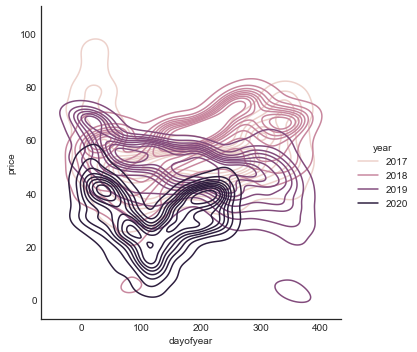

In [27]:
  sns.displot(x = df["dayofyear"], 
              y = df["price"],
              hue = df["year"],
              kind = "kde");

It's interesting to note that in 2020 versus other years there seems to be a markedly lower overall price with large dips during the shutdown period. Versus previous years there seems to be a tighter distribution. 

In [28]:
df = train
cat = categorical+boolean

@ipw.interact(num1 = ipw.Dropdown(options = numeric), cat1 = ipw.Dropdown(options = cat))
def plot_hist(num1, cat1):
  sns.displot(x = df[num1], y = df["price"], kind = "kde", hue = df[cat1])


interactive(children=(Dropdown(description='num1', options=('hour', 'net_energy', 'thermal_gap', 'production',…

In [29]:
df = train
cat = categorical+boolean

@ipw.interact(column_name = ipw.Dropdown(options = cat))
def plot_hist(column_name):
  sns.barplot(x = df[column_name], y = df["price"])

interactive(children=(Dropdown(description='column_name', options=('season', 'dayofweek', 'month', 'covid', 'i…

## Variable Correlations

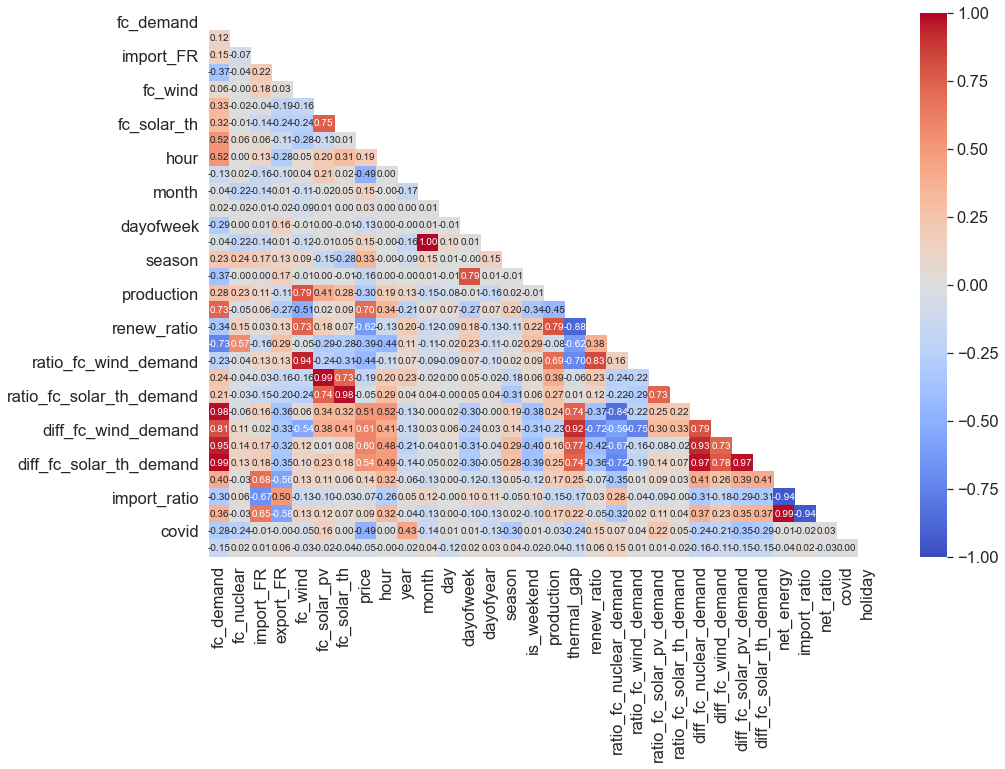

In [30]:
plt.figure(figsize=(15, 10))
sns.set(font_scale=1.5)
sns.set_style('white')
corr = train.corr()
mask = np.triu(np.ones_like(corr, dtype=bool)) # Generating a mask for the upper triangle
sns.heatmap(corr, cmap='coolwarm', fmt='.2f', annot=True, mask=mask, annot_kws={'size':10}, vmin = -1, vmax = 1)
plt.show()

### NOTES:
- We don't need to keep both month & day of year - duplicative data; should test different combos to see what predicts better
- We have collinearity between the components of demand and demand itself; at least a few should be dropped
- Net energy is a combination of import and export so we might want to drop either import or export and look at accuracy
- Price correlations:
    - **HIGH:**
        - (-) covid - lower pricing
        - (+) thermal gap; more production from expensive sources more expensive things are
        - (+/-) differences and ratios between other sources
    - **LOW:** Might be good candidates for dropping to reduce colinearity
        - net_ratio
        - import_ratio
        - net_energy
        - ratio_fc_solar_th_demand
        - day
        - fc_solar_th
        - fc_wind
        - fc_nuclear

# Processing 

In [31]:
print(train.isnull().sum(axis=0))
print(test.isnull().sum(axis=0))

fc_demand                    0
fc_nuclear                   0
import_FR                   13
export_FR                   13
fc_wind                      0
fc_solar_pv                  0
fc_solar_th                  0
price                        0
date                         0
hour                         0
datetime                     0
year                         0
month                        0
day                          0
dayofweek                    0
dayofyear                    0
season                       0
is_weekend                   0
production                   0
thermal_gap                  0
renew_ratio                  0
ratio_fc_nuclear_demand      0
ratio_fc_wind_demand         0
ratio_fc_solar_pv_demand     0
ratio_fc_solar_th_demand     0
diff_fc_nuclear_demand       0
diff_fc_wind_demand          0
diff_fc_solar_pv_demand      0
diff_fc_solar_th_demand      0
net_energy                  13
import_ratio                13
net_ratio                   13
covid   

In [32]:
train.fillna(method='ffill', inplace=True)
test.fillna(method = "ffill", inplace = True)

print(train.isnull().sum(axis=0))
print(test.isnull().sum(axis=0))

fc_demand                   0
fc_nuclear                  0
import_FR                   0
export_FR                   0
fc_wind                     0
fc_solar_pv                 0
fc_solar_th                 0
price                       0
date                        0
hour                        0
datetime                    0
year                        0
month                       0
day                         0
dayofweek                   0
dayofyear                   0
season                      0
is_weekend                  0
production                  0
thermal_gap                 0
renew_ratio                 0
ratio_fc_nuclear_demand     0
ratio_fc_wind_demand        0
ratio_fc_solar_pv_demand    0
ratio_fc_solar_th_demand    0
diff_fc_nuclear_demand      0
diff_fc_wind_demand         0
diff_fc_solar_pv_demand     0
diff_fc_solar_th_demand     0
net_energy                  0
import_ratio                0
net_ratio                   0
covid                       0
holiday   

# Feature Importance & Base Model

In [33]:
#Examining test data to determine date cutoff on our training / validation splits 
print(test["date"].max())
print(test["date"].min())
print(test["date"].max()-test["date"].min())

2021-01-31 00:00:00
2020-09-01 00:00:00
152 days 00:00:00


In [34]:
#Date Cutoff
train["date"].max() - (test["date"].max()-test["date"].min())

Timestamp('2020-04-01 00:00:00')

In [35]:
#Manually Split Data:

def train_test_split(data, date_split):

    # training vs target
    x = data.drop(["datetime", "price"], axis=1)
    y = data[["date", "price"]]

    # splitting data
    x_train = x[x["date"] < date_split].drop("date", axis=1)
    x_test = x[x["date"] >= date_split].drop("date", axis=1)
    y_train = y[y["date"] < date_split].drop("date", axis=1).values.ravel()
    y_test = y[y["date"] >= date_split].drop("date", axis=1).values.ravel()

    print(f"x_train: {x_train.shape}")
    print(f"x_test: {x_test.shape}")
    print(f"y_train: {y_train.shape}")
    print(f"y_test: {y_test.shape}")
    
    return x_train, x_test, y_train, y_test

date_split = pd.to_datetime("2020-04-01")
x_train, x_test, y_train, y_test = train_test_split(train, date_split)

x_train: (28463, 31)
x_test: (3672, 31)
y_train: (28463,)
y_test: (3672,)


Root Mean squared error: 8.27
Coefficient of determination: 0.28
MAPE: 33.85
None


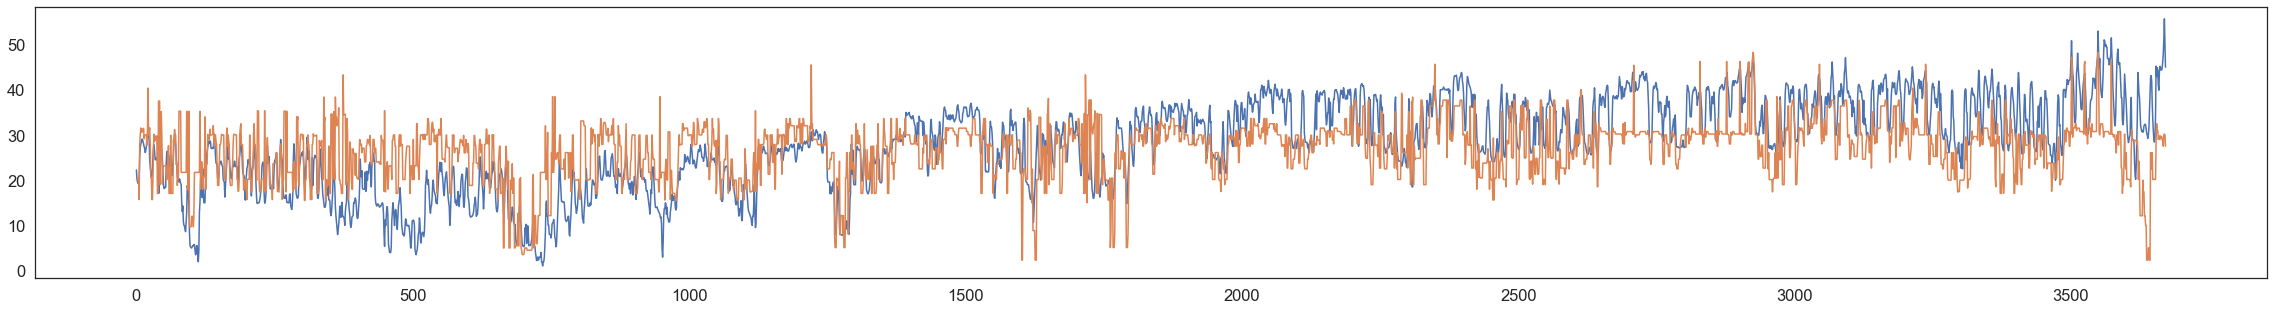

In [36]:
#manual data split & performance evalution
dt = DecisionTreeRegressor(random_state=42)

dt.fit(x_train, y_train)
dt.score(x_test, y_test)

y_hat_test = dt.predict(x_test)

#Measure Test:
print(evaluate(y_test, y_hat_test))

#Plot Test:
fig , ax = plt.subplots(figsize =(40,5))
pd.Series(y_test).plot(ax =ax , label = "train")
pd.Series(y_hat_test).plot(ax =ax , label = "prediction");

In [37]:
feat_imp = dt.feature_importances_
features = x_train.columns
feat_imp_dt = pd.DataFrame({
    "feature": features, 
    "importance": feat_imp
}).sort_values(by="importance", ascending=False).reset_index(drop=True)
feat_imp_dt

,feature,importance
0,thermal_gap,4.594168e-01
1,year,1.714825e-01
2,dayofyear,1.443261e-01
3,season,6.336892e-02
4,import_FR,2.608303e-02
5,import_ratio,2.466360e-02
6,day,1.443591e-02
7,net_ratio,1.294279e-02
8,export_FR,1.199950e-02
9,fc_nuclear,1.066486e-02


**Hyperparameter Tuning:**

max_depth: 1, rmse_train: 10.964, rmse_test=20.274
max_depth: 2, rmse_train: 9.875, rmse_test=17.360
max_depth: 3, rmse_train: 8.779, rmse_test=9.677
max_depth: 4, rmse_train: 7.805, rmse_test=9.143
max_depth: 5, rmse_train: 7.023, rmse_test=8.783
max_depth: 6, rmse_train: 6.455, rmse_test=8.150
max_depth: 7, rmse_train: 5.722, rmse_test=8.116
max_depth: 8, rmse_train: 4.958, rmse_test=8.501
max_depth: 9, rmse_train: 4.342, rmse_test=8.444
max_depth: 10, rmse_train: 3.750, rmse_test=8.870
max_depth: 11, rmse_train: 3.200, rmse_test=8.470
max_depth: 12, rmse_train: 2.708, rmse_test=8.456
max_depth: 13, rmse_train: 2.309, rmse_test=8.944
max_depth: 14, rmse_train: 1.922, rmse_test=8.562
max_depth: 15, rmse_train: 1.562, rmse_test=8.319
max_depth: 16, rmse_train: 1.247, rmse_test=8.621
max_depth: 17, rmse_train: 0.984, rmse_test=8.308
max_depth: 18, rmse_train: 0.763, rmse_test=8.412
max_depth: 19, rmse_train: 0.569, rmse_test=8.798
max_depth: 20, rmse_train: 0.431, rmse_test=8.470
max_de

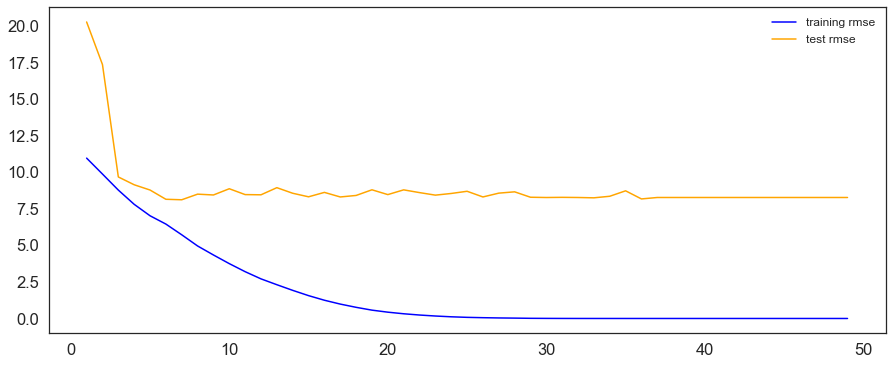

In [39]:
max_depth_range = range(1, 50)

error_results = []

# looping through values of max_depth
for max_depth in max_depth_range:
    
    # parameters
    parameters = {
        "max_depth": max_depth,
        "random_state": 42
    }

    # train
    dt_2 = DecisionTreeRegressor(**parameters)
    dt_2.fit(x_train, y_train)
    
    # predict
    y_hat_train = dt_2.predict(x_train)  # prediction on the training set
    y_hat_test = dt_2.predict(x_test)  # prediction on the test set
        
    # evaluate
    rmse_train = mean_squared_error(y_train, y_hat_train, squared = False)
    rmse_test = mean_squared_error(y_test, y_hat_test, squared = False)
        
    # store results
    error_results.append({
        "max_depth": max_depth, 
        "rmse_train": rmse_train,
        "rmse_test": rmse_test
    })
    
    # print evolution of loop:
    print(f"max_depth: {max_depth}, rmse_train: {rmse_train:.3f}, rmse_test={rmse_test:.3f}")
    
# saving results as dataframe
results = pd.DataFrame(error_results)

# plotting
fig, ax = plt.subplots(figsize=(15, 6))

ax.plot(results["max_depth"], results["rmse_train"], label="training rmse", color="blue")
ax.plot(results["max_depth"], results["rmse_test"], label="test rmse", color="orange")
ax.legend(fontsize=12)

plt.show()

Training RMSE decreases w/ increased depth. Test RMSE elbows at 2 with another slight dip at 6-7. 

min_samples_leaf: 1, rmse_train: 6.455, rmse_test=8.150
min_samples_leaf: 2, rmse_train: 6.455, rmse_test=8.150
min_samples_leaf: 3, rmse_train: 6.455, rmse_test=8.150
min_samples_leaf: 4, rmse_train: 6.456, rmse_test=8.121
min_samples_leaf: 5, rmse_train: 6.458, rmse_test=8.121
min_samples_leaf: 6, rmse_train: 6.458, rmse_test=8.114
min_samples_leaf: 7, rmse_train: 6.458, rmse_test=8.126
min_samples_leaf: 8, rmse_train: 6.460, rmse_test=8.126
min_samples_leaf: 9, rmse_train: 6.460, rmse_test=8.126
min_samples_leaf: 10, rmse_train: 6.462, rmse_test=8.128
min_samples_leaf: 11, rmse_train: 6.463, rmse_test=8.128
min_samples_leaf: 12, rmse_train: 6.463, rmse_test=8.128
min_samples_leaf: 13, rmse_train: 6.464, rmse_test=8.123
min_samples_leaf: 14, rmse_train: 6.465, rmse_test=8.123
min_samples_leaf: 15, rmse_train: 6.465, rmse_test=8.123
min_samples_leaf: 16, rmse_train: 6.471, rmse_test=8.123
min_samples_leaf: 17, rmse_train: 6.471, rmse_test=8.123
min_samples_leaf: 18, rmse_train: 6.471,

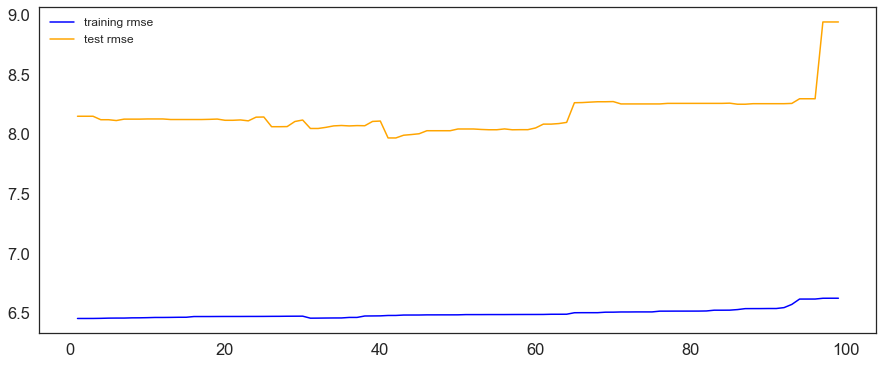

In [40]:
min_samples_range = range(1, 100)
max_depth = 6

error_results = []

# looping through values of max_depth
for min_samples in min_samples_range:
    
    # parameters
    parameters = {
        "max_depth": max_depth,
        "random_state": 42,
        "min_samples_leaf" : min_samples
    }

    # train
    dt_2 = DecisionTreeRegressor(**parameters)
    dt_2.fit(x_train, y_train)
    
    # predict
    y_hat_train = dt_2.predict(x_train)  # prediction on the training set
    y_hat_test = dt_2.predict(x_test)  # prediction on the test set
        
    # evaluate
    rmse_train = mean_squared_error(y_train, y_hat_train, squared = False)
    rmse_test = mean_squared_error(y_test, y_hat_test, squared = False)
        
    # store results
    error_results.append({
        "min_samples": min_samples, 
        "rmse_train": rmse_train,
        "rmse_test": rmse_test
    })
    
    # print evolution of loop:
    print(f"min_samples_leaf: {min_samples}, rmse_train: {rmse_train:.3f}, rmse_test={rmse_test:.3f}")
    
# saving results as dataframe
results = pd.DataFrame(error_results)

# plotting
fig, ax = plt.subplots(figsize=(15, 6))

ax.plot(results["min_samples"], results["rmse_train"], label="training rmse", color="blue")
ax.plot(results["min_samples"], results["rmse_test"], label="test rmse", color="orange")
ax.legend(fontsize=12)

plt.show()

Given max_depth = 6, we can see that we had best performance between 40-60 min samples.

min_samples_leaf: 1, rmse_train: 5.722, rmse_test=8.116
min_samples_leaf: 2, rmse_train: 5.723, rmse_test=8.116
min_samples_leaf: 3, rmse_train: 5.725, rmse_test=8.187
min_samples_leaf: 4, rmse_train: 5.728, rmse_test=8.142
min_samples_leaf: 5, rmse_train: 5.729, rmse_test=8.134
min_samples_leaf: 6, rmse_train: 5.730, rmse_test=8.129
min_samples_leaf: 7, rmse_train: 5.730, rmse_test=8.137
min_samples_leaf: 8, rmse_train: 5.733, rmse_test=8.355
min_samples_leaf: 9, rmse_train: 5.734, rmse_test=8.355
min_samples_leaf: 10, rmse_train: 5.736, rmse_test=8.266
min_samples_leaf: 11, rmse_train: 5.739, rmse_test=8.094
min_samples_leaf: 12, rmse_train: 5.739, rmse_test=8.012
min_samples_leaf: 13, rmse_train: 5.739, rmse_test=8.012
min_samples_leaf: 14, rmse_train: 5.741, rmse_test=7.870
min_samples_leaf: 15, rmse_train: 5.741, rmse_test=7.986
min_samples_leaf: 16, rmse_train: 5.750, rmse_test=7.986
min_samples_leaf: 17, rmse_train: 5.750, rmse_test=7.985
min_samples_leaf: 18, rmse_train: 5.750,

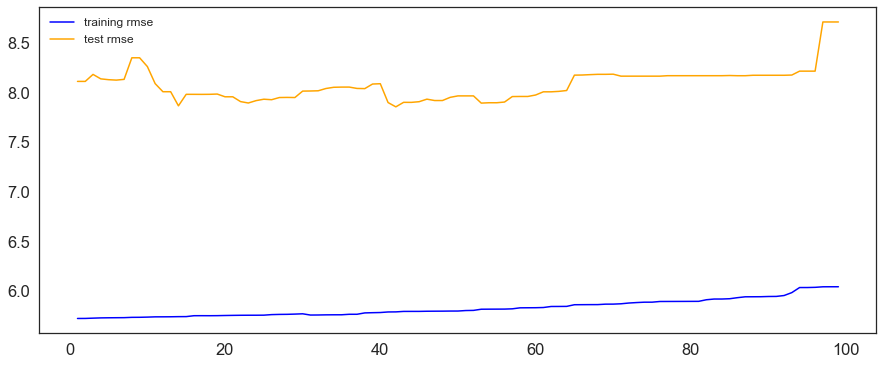

In [41]:
min_samples_range = range(1, 100)
max_depth = 7

error_results = []

# looping through values of max_depth
for min_samples in min_samples_range:
    
    # parameters
    parameters = {
        "max_depth": max_depth,
        "random_state": 42,
        "min_samples_leaf" : min_samples
    }

    # train
    dt_2 = DecisionTreeRegressor(**parameters)
    dt_2.fit(x_train, y_train)
    
    # predict
    y_hat_train = dt_2.predict(x_train)  # prediction on the training set
    y_hat_test = dt_2.predict(x_test)  # prediction on the test set
        
    # evaluate
    rmse_train = mean_squared_error(y_train, y_hat_train, squared = False)
    rmse_test = mean_squared_error(y_test, y_hat_test, squared = False)
        
    # store results
    error_results.append({
        "min_samples": min_samples, 
        "rmse_train": rmse_train,
        "rmse_test": rmse_test
    })
    
    # print evolution of loop:
    print(f"min_samples_leaf: {min_samples}, rmse_train: {rmse_train:.3f}, rmse_test={rmse_test:.3f}")
    
# saving results as dataframe
results = pd.DataFrame(error_results)

# plotting
fig, ax = plt.subplots(figsize=(15, 6))

ax.plot(results["min_samples"], results["rmse_train"], label="training rmse", color="blue")
ax.plot(results["min_samples"], results["rmse_test"], label="test rmse", color="orange")
ax.legend(fontsize=12)

plt.show()

Given max_depth = 7 we're seeing a similar window of "best performance" between 40-60.

**Tweak Inputs:**

Root Mean squared error: 7.86
Coefficient of determination: 0.35
MAPE: 34.64
None


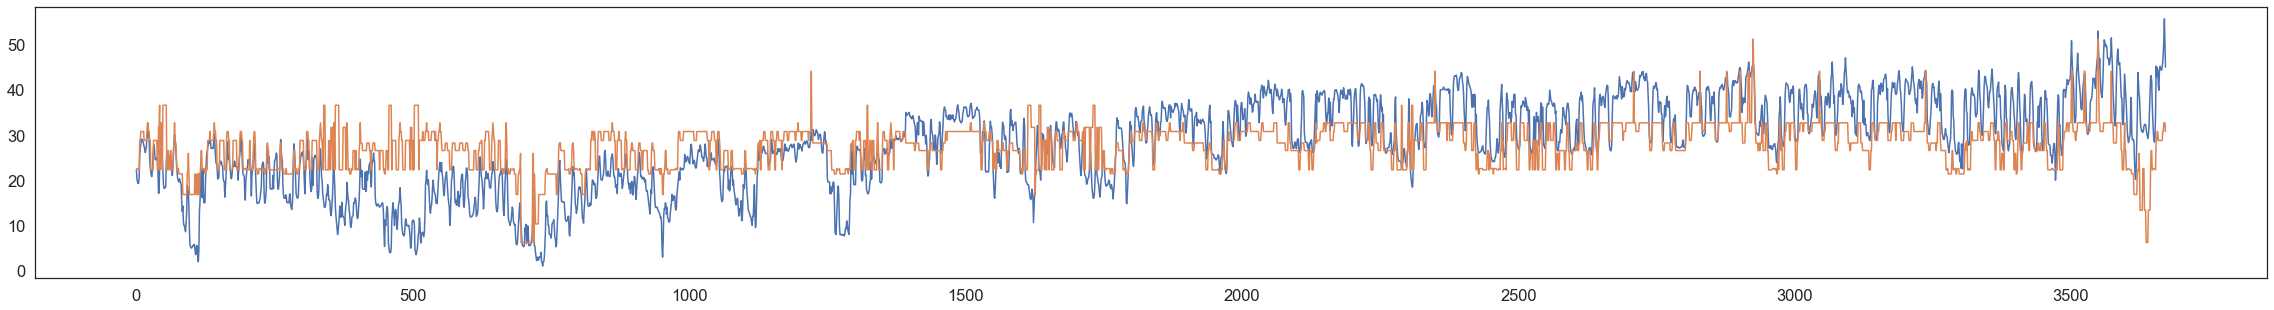

In [42]:
#manual data split & performance evalution
dt = DecisionTreeRegressor(random_state=42, max_depth = 7, min_samples_leaf = 42)

dt.fit(x_train, y_train)
dt.score(x_test, y_test)

y_hat_test = dt.predict(x_test)

#Measure Test:
print(evaluate(y_test, y_hat_test))

#Plot Test:
fig , ax = plt.subplots(figsize =(40,5))
pd.Series(y_test).plot(ax =ax , label = "train")
pd.Series(y_hat_test).plot(ax =ax , label = "prediction");

max_depth = 7, min_samples_leaf = 42 improves our RMSE and more importantly makes our model less prone to overfitting, increasing its ability to predict unseen data.

In [43]:
feat_imp = dt.feature_importances_
features = x_train.columns
feat_imp_dt = pd.DataFrame({
    "feature": features, 
    "importance": feat_imp
}).sort_values(by="importance", ascending=False).reset_index(drop=True)
feat_imp_dt

,feature,importance
0,thermal_gap,0.553161
1,year,0.189230
2,dayofyear,0.121242
3,season,0.073810
4,import_ratio,0.022970
5,import_FR,0.017929
6,export_FR,0.007945
7,day,0.004517
8,net_ratio,0.003618
9,fc_nuclear,0.001758


Checking our feature importance again; our bottom performing features after tuning our tree based model are: 

- diff_fc_solar_th_demand
- diff_fc_nuclear_demand
- covid
- fc_demand
- ratio_fc_solar_th_demand
- ratio_fc_solar_pv_demand
- is_weekend
- month
- fc_solar_th
- fc_solar_pv
- fc_wind
- holiday

# PCA

In [44]:
train.iloc[:,1:10].head(2)

,fc_nuclear,import_FR,export_FR,fc_wind,fc_solar_pv,fc_solar_th,price,date,hour
0,7117.2,3000.0,2600.0,1732.0,0.0,5.1,58.82,2017-01-01,0
1,7117.2,3000.0,2650.0,1826.0,0.0,0.6,58.23,2017-01-01,1


In [45]:
dataset = train.drop(columns = ["price", "date", "datetime"])
scaled = StandardScaler().fit_transform(dataset)

pca_test = PCA()
principal_components = pca_test.fit_transform(scaled)
pd.DataFrame(principal_components).describe()

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,30
count,3.213500e+04,32135.000000,3.213500e+04,32135.000000,32135.000000,32135.000000,32135.000000,3.213500e+04,3.213500e+04,3.213500e+04,...,3.213500e+04,3.213500e+04,3.213500e+04,3.213500e+04,3.213500e+04,3.213500e+04,3.213500e+04,3.213500e+04,3.213500e+04,3.213500e+04
mean,2.830231e-17,0.000000,1.415115e-17,0.000000,0.000000,0.000000,0.000000,2.830231e-17,-1.132092e-16,8.490693e-17,...,2.211118e-18,-3.811414e-17,6.028849e-18,-4.698067e-17,9.831738e-18,-1.923554e-17,-1.039919e-18,3.560394e-17,1.473868e-19,7.306303e-18
std,2.849687e+00,2.095967,1.992067e+00,1.618767,1.458993,1.341745,1.197723,1.098794e+00,1.054137e+00,1.040431e+00,...,5.062951e-02,2.374819e-03,1.297178e-15,3.945319e-16,2.783958e-16,2.747491e-16,2.556101e-16,2.494166e-16,2.519450e-16,1.971081e-16
min,-7.025413e+00,-6.478899,-3.893764e+00,-5.608024,-3.427764,-3.558854,-4.364851,-3.981998e+00,-3.481832e+00,-2.690645e+00,...,-3.359129e-01,-7.606428e-03,-4.562053e-14,-1.728799e-14,-6.389756e-15,-1.313892e-14,-1.220599e-14,-5.357443e-15,-9.118410e-15,-1.223963e-14
25%,-2.336835e+00,-1.488244,-1.449103e+00,-1.059079,-1.094855,-0.901233,-0.816616,-7.284149e-01,-7.571398e-01,-7.066012e-01,...,-2.142882e-02,-1.820181e-03,-5.813503e-16,-2.212158e-16,-7.475514e-17,-1.720150e-16,-1.309743e-16,-1.108536e-16,-1.295809e-16,-7.270722e-17
50%,-1.822937e-01,-0.152161,-3.717299e-01,-0.041488,-0.093053,0.014757,-0.031799,1.767470e-02,-2.923710e-02,-6.854044e-02,...,4.178459e-03,2.066552e-04,8.053863e-18,-4.364357e-17,8.642812e-18,-1.751847e-17,1.884168e-18,3.264723e-17,-1.193849e-18,7.823761e-18
75%,2.343565e+00,1.362780,1.094701e+00,1.065375,0.882883,0.805075,0.815219,7.277027e-01,7.925265e-01,5.628649e-01,...,2.488116e-02,1.830289e-03,5.765386e-16,1.279077e-16,9.207125e-17,1.328431e-16,1.336852e-16,1.760147e-16,1.298842e-16,9.231023e-17
max,7.514481e+00,8.359098,8.044403e+00,6.496023,4.065820,5.265070,5.030737,5.078282e+00,3.638388e+00,5.353786e+00,...,4.116225e-01,1.494620e-02,1.035303e-13,3.590452e-14,4.294177e-14,1.471440e-14,1.342345e-14,1.263092e-14,1.308929e-14,1.921129e-14


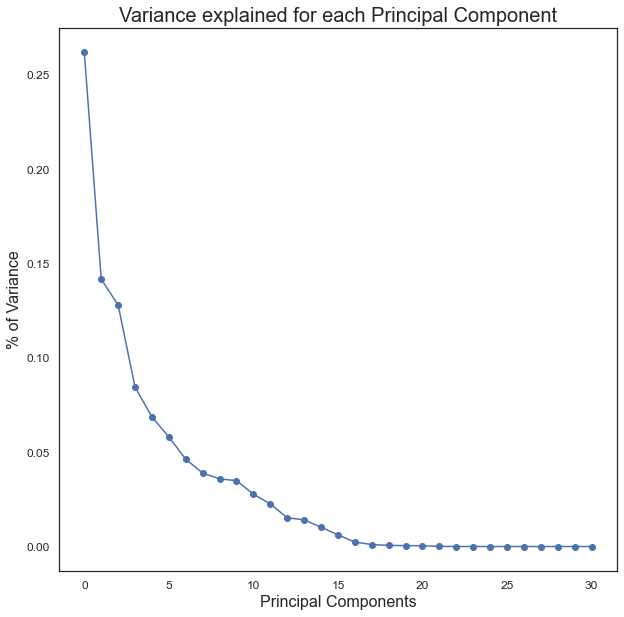

In [46]:
plt.figure(figsize=(10,10))
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title("Variance explained for each Principal Component", fontsize=20)
plt.plot(pca_test.explained_variance_ratio_, 'o-')
plt.xlabel("Principal Components", fontsize=16)
plt.ylabel("% of Variance", fontsize=16);

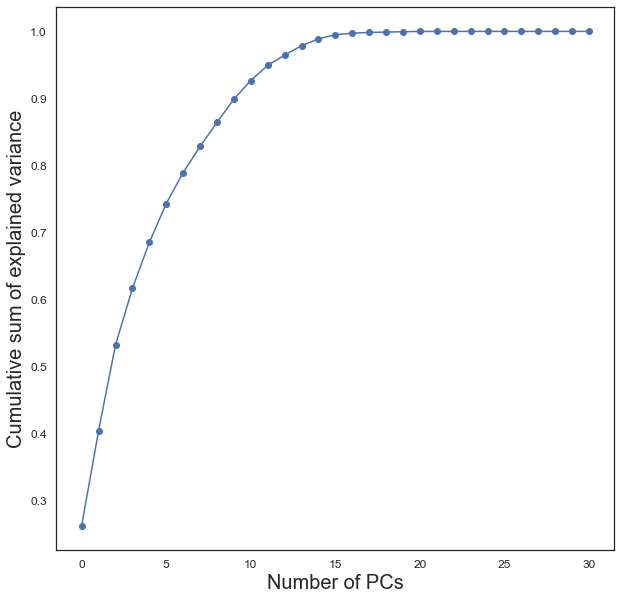

In [47]:
plt.figure(figsize=(10,10))
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.plot(np.cumsum(pca_test.explained_variance_ratio_), '-o')
plt.xlabel('Number of PCs', fontsize=20)
plt.ylabel('Cumulative sum of explained variance' , fontsize=20);

In [48]:
model = Pipeline([
                ("Scaler", StandardScaler()),
                ("PCA", PCA()),
                ("Engine", DecisionTreeRegressor(random_state=42, max_depth = 7, min_samples_leaf = 42))
])

n_components = list(range(1,30))

param_grid = {"PCA__n_components": n_components, 
             "Engine__max_features": [0.6, 0.7, 0.8, "auto"]
             }

estimator = GridSearchCV(model, param_grid, n_jobs= -1 , scoring = "neg_root_mean_squared_error", cv = TimeSeriesSplit().split(x_train))
estimator.fit(x_train, y_train)

GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x7fc07bc15250>,
             estimator=Pipeline(steps=[('Scaler', StandardScaler()),
                                       ('PCA', PCA()),
                                       ('Engine',
                                        DecisionTreeRegressor(max_depth=7,
                                                              min_samples_leaf=42,
                                                              random_state=42))]),
             n_jobs=-1,
             param_grid={'Engine__max_features': [0.6, 0.7, 0.8, 'auto'],
                         'PCA__n_components': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10,
                                               11, 12, 13, 14, 15, 16, 17, 18,
                                               19, 20, 21, 22, 23, 24, 25, 26,
                                               27, 28, 29]},
             scoring='neg_root_mean_squared_error')

In [49]:
estimator.best_estimator_

Pipeline(steps=[('Scaler', StandardScaler()), ('PCA', PCA(n_components=3)),
                ('Engine',
                 DecisionTreeRegressor(max_depth=7, max_features=0.7,
                                       min_samples_leaf=42, random_state=42))])

In [50]:
estimator.best_score_

-11.156210540353891

After looking at the feature importance and selecting the variables to discard, we filter the more relevant variables in the previously assigned lists considering the different types of variables.

In [51]:
#Testing on only top performing variables:
drop_cols = ["diff_fc_solar_th_demand", "diff_fc_nuclear_demand", "covid", "fc_demand", "ratio_fc_solar_th_demand",
             "ratio_fc_solar_pv_demand","is_weekend", "month", "fc_solar_th", "fc_solar_pv", "fc_wind", "holiday"]

x_train_dropped = x_train.drop(columns = drop_cols)
x_test_dropped = x_test.drop(columns = drop_cols)


In [52]:
model = Pipeline([
                ("Scaler", StandardScaler()),
                ("PCA", PCA()),
                ("Engine", DecisionTreeRegressor(random_state=42, max_depth = 7, min_samples_leaf = 42, max_features=0.7))
])

n_components = list(range(1,19))

param_grid = {"PCA__n_components": n_components}

estimator = GridSearchCV(model, param_grid, n_jobs = -1 ,  scoring = "neg_root_mean_squared_error", cv = TimeSeriesSplit().split(x_train_dropped))
estimator.fit(x_train_dropped, y_train)

GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x7fc0846674d0>,
             estimator=Pipeline(steps=[('Scaler', StandardScaler()),
                                       ('PCA', PCA()),
                                       ('Engine',
                                        DecisionTreeRegressor(max_depth=7,
                                                              max_features=0.7,
                                                              min_samples_leaf=42,
                                                              random_state=42))]),
             n_jobs=-1,
             param_grid={'PCA__n_components': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10,
                                               11, 12, 13, 14, 15, 16, 17,
                                               18]},
             scoring='neg_root_mean_squared_error')

In [53]:
estimator.best_estimator_

Pipeline(steps=[('Scaler', StandardScaler()), ('PCA', PCA(n_components=2)),
                ('Engine',
                 DecisionTreeRegressor(max_depth=7, max_features=0.7,
                                       min_samples_leaf=42, random_state=42))])

In [54]:
estimator.best_score_

-10.713875907541397

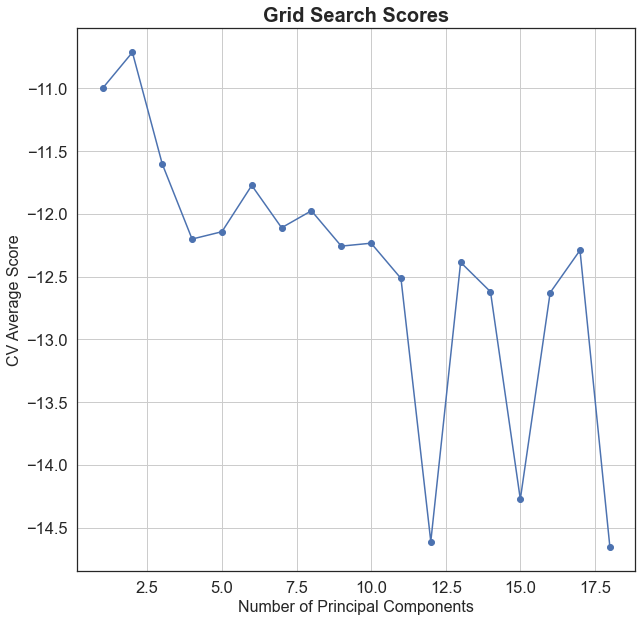

In [55]:
# Get Test Scores Mean and std for each grid search
scores_mean = estimator.cv_results_['mean_test_score']
scores_mean = np.array(scores_mean)

scores_sd = estimator.cv_results_['std_test_score']
scores_sd = np.array(scores_sd)

# Plot Grid search scores
plt.figure(figsize=(10,10))
plt.plot(n_components, scores_mean, '-o')


plt.title("Grid Search Scores", fontsize=20, fontweight='bold')
plt.xlabel("Number of Principal Components", fontsize=16)
plt.ylabel('CV Average Score', fontsize=16)
plt.grid('on')


**Combining PCA with our original test / train split to evaluate performance:**

Root Mean squared error: 18.65
Coefficient of determination: -2.65
MAPE: 83.94
None


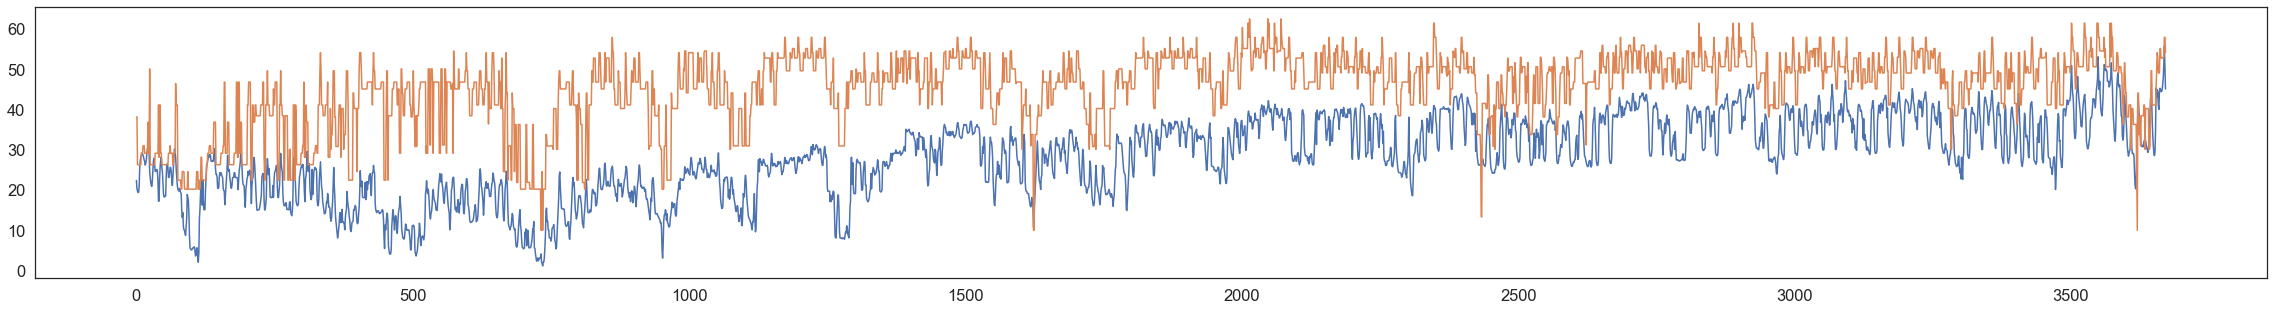

In [56]:
model = Pipeline([
                ("Scaler", StandardScaler()),
                ("PCA", PCA(n_components = 5)),
                ("Engine", DecisionTreeRegressor(random_state=42, max_depth = 7, min_samples_leaf = 42))
])


model.fit(x_train, y_train)
model.score(x_test, y_test)

y_hat_test = model.predict(x_test)

#Measure Test:
print(evaluate(y_test, y_hat_test))

#Plot Test:
fig , ax = plt.subplots(figsize =(40,5))
pd.Series(y_test).plot(ax =ax , label = "train")
pd.Series(y_hat_test).plot(ax =ax , label = "prediction");

Root Mean squared error: 18.30
Coefficient of determination: -2.51
MAPE: 80.18
None


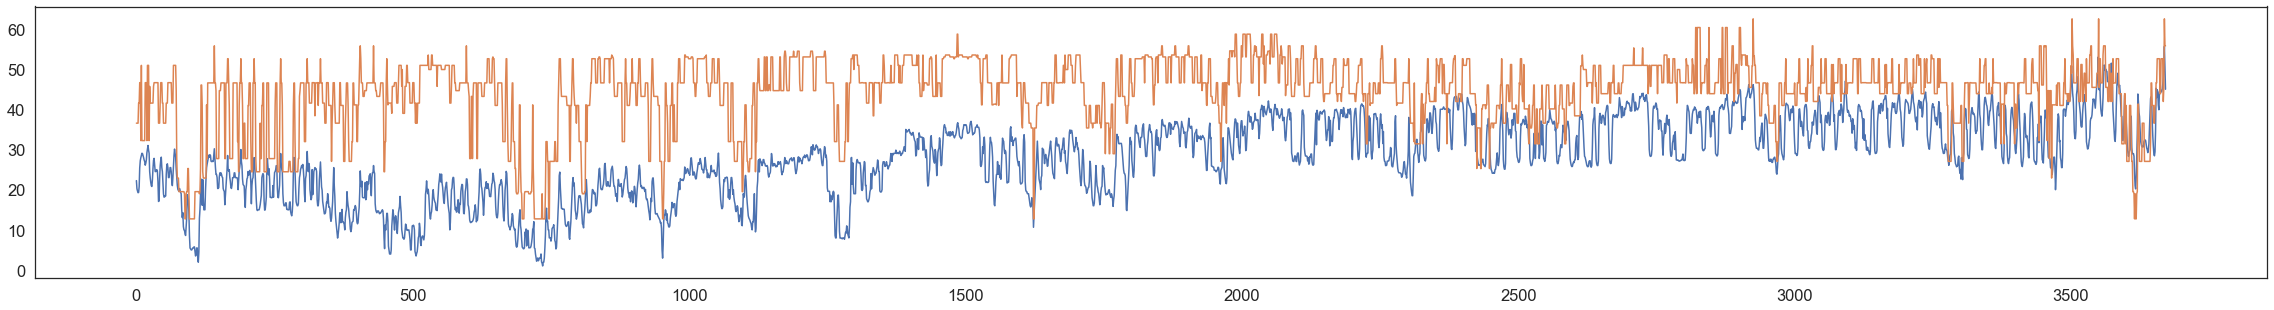

In [57]:
model = Pipeline([
                ("Scaler", StandardScaler()),
                ("PCA", PCA(n_components = 5)),
                ("Engine", DecisionTreeRegressor(random_state=42, max_depth = 7, min_samples_leaf = 42))
])


model.fit(x_train_dropped, y_train)
model.score(x_test_dropped, y_test)

y_hat_test = model.predict(x_test_dropped)

#Measure Test:
print(evaluate(y_test, y_hat_test))

#Plot Test:
fig , ax = plt.subplots(figsize =(40,5))
pd.Series(y_test).plot(ax =ax , label = "train")
pd.Series(y_hat_test).plot(ax =ax , label = "prediction");

## Base model XGB

**Recall our train & test splits from above - 
we will continue to use this framework as we evaluate our more complex model:**
- x_train: (28463, 31)
- x_test: (3672, 31)
- y_train: (28463,)
- y_test: (3672,)

**We'll start by testing the top five parameters with the best performance in our base model:**
- thermal_gap
- year
- dayofyear
- season
- import_ratio

In [58]:
best_parameters = ["thermal_gap", "year", "dayofyear", "season", "import_ratio"]

x_train_dropped = x_train[best_parameters]
x_test_dropped = x_test[best_parameters]

In [59]:
x_train_dropped.dtypes

thermal_gap     float64
year              int64
dayofyear         int64
season            int64
import_ratio    float64
dtype: object

[14:47:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Root Mean squared error: 7.35
Coefficient of determination: 0.43
MAPE: 31.48


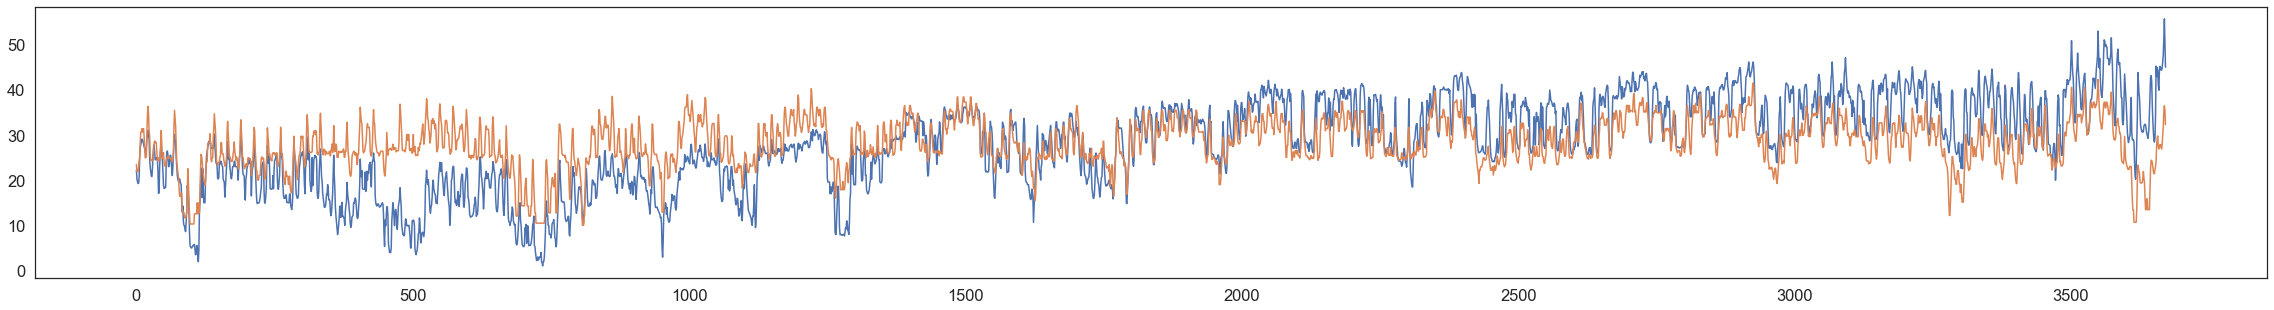

In [60]:
best_xgb_model = XGBRegressor(
                 seed=42, n_jobs =-1
)
best_xgb_model.fit(x_train_dropped,y_train)

y_hat_test = best_xgb_model.predict(x_test_dropped)

#Measure Test:
evaluate(y_test, y_hat_test)

#Plot Test:
fig , ax = plt.subplots(figsize =(40,5))
pd.Series(y_test).plot(ax =ax , label = "train")
pd.Series(y_hat_test).plot(ax =ax , label = "prediction");

Already we can see our XGBoost model is better than our base decision tree regression in producing a better RMSE. Next well go ahead and tune our hyperparameters. 

# We will choose several parameters to hypertune our model:
1. learning_rate = Step size shrinkage used in update to prevents overfitting. After each boosting step, we can directly get the weights of new features range: [0,1]
2. max_depth =  Maximum depth of a tree. Increasing this value will make the model more complex and more likely to overfit. The default is 6, however we will test slightly lower and slightly (but not much) higher based on our performance in the decision tree regressor. 
3. 'n_estimators':[10], #number of trees you want to build
4. subsample':[0.6,0.8],  #[0.6,0.8]Setting it to 0.5 means that XGBoost would randomly sample half of the training data prior to growing trees. and this will prevent overfitting. Subsampling will occur once in every boosting iteration.range: (0,1] The second way is to add randomness to make training robust to noise.


In [64]:
xgb_paramter = parameters_for_testing = {
    'learning_rate':[0.03 , 0.01], # step size shrinkage used to prevent overfitting. Range is [0,1]
    'max_depth':[2,3,4,5,6,7], #determines how deeply each tree is allowed to grow during any boosting round.
    'n_estimators':[60,80,100], #number of trees you want to build
    'subsample':[0.5,0.7],  #[0.6,0.8]Setting it to 0.5 means that XGBoost would randomly sample half of the training data prior to growing trees. and this will prevent overfitting. Subsampling will occur once in every boosting iteration.range: (0,1]
}


gsearch_xgb = GridSearchCV(estimator = XGBRegressor(random_state = 42), param_grid = xgb_paramter, n_jobs= -1 , cv = TimeSeriesSplit().split(x_train_dropped))
gsearch_xgb.fit(x_train_dropped,y_train)

[14:52:38] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x7fc084667450>,
             estimator=XGBRegressor(random_state=42), n_jobs=-1,
             param_grid={'learning_rate': [0.03, 0.01],
                         'max_depth': [2, 3, 4, 5, 6, 7],
                         'n_estimators': [60, 80, 100],
                         'subsample': [0.5, 0.7]})

In [65]:
print('best params')
print (gsearch_xgb.best_params_)
print('best score')
print (gsearch_xgb.best_score_)

best params
{'learning_rate': 0.03, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.5}
best score
-0.2677701093914295


Now that our model is cleaned up and not as likely to overfit, we'll do a final test with the model on the full actual dataset that we'll be using to predict our unseen prices file.

[14:52:39] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[60.631298 58.05157  51.4158   ... 44.271854 43.789276 41.56357 ]
Root Mean squared error: 3.72
Coefficient of determination: 0.94
MAPE: 8.80


<AxesSubplot:>

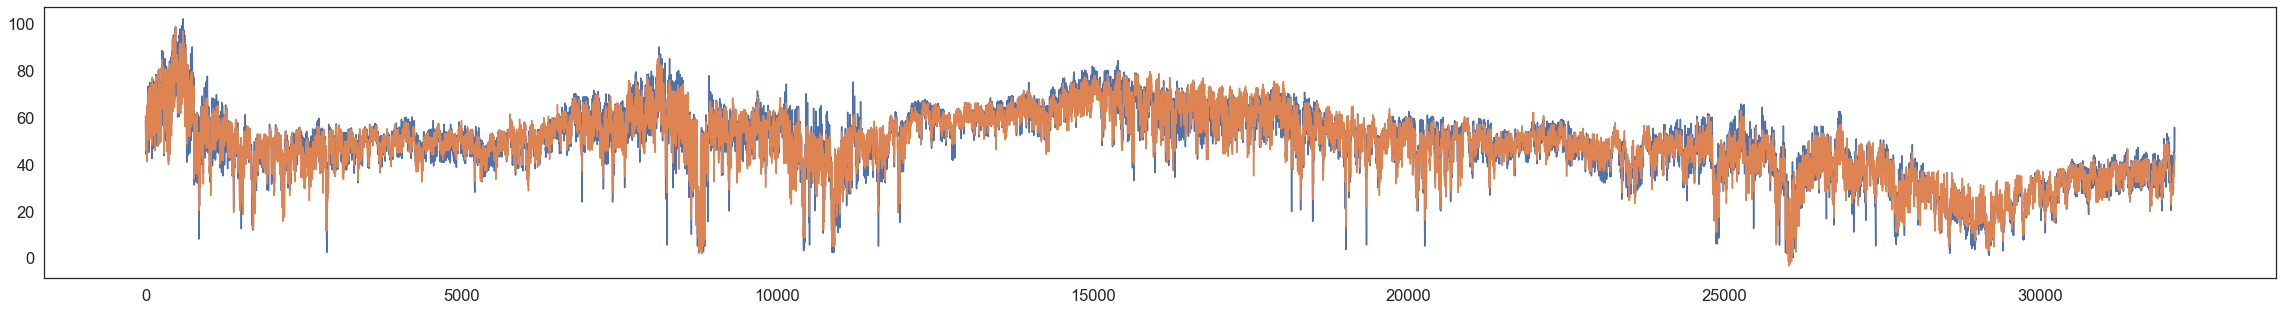

In [66]:
final_x_train = train[best_parameters]
final_y_train = train.price
final_x_test = test[best_parameters]

model_XGB= XGBRegressor(
                 learning_rate=0.3,
                 max_depth=3,
                 n_estimators= 100,                                                                    
                 subsample=0.5,
                 seed=42, n_jobs =-1
)

model_XGB.fit(final_x_train, final_y_train)
y_hat_xgb = model_XGB.predict(final_x_train)

print(y_hat_xgb)

evaluate(final_y_train , y_hat_xgb)
fig , ax = plt.subplots(figsize =(40,5))
pd.Series(final_y_train.to_numpy()).plot(ax =ax , label = "train")
pd.Series(y_hat_xgb).plot(ax =ax , label = "prediction")


In [67]:
best_xgb_model = XGBRegressor(
                 learning_rate=0.3,
                 max_depth=3,
                 n_estimators= 100,                                                                    
                 subsample=0.5,
                 seed=42, n_jobs =-1
)
best_xgb_model.fit(final_x_train,final_y_train)

[14:52:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(learning_rate=0.3, n_jobs=-1, seed=42, subsample=0.5)

In [68]:
y_hat_xgb_best = best_xgb_model.predict(final_x_train)
print(best_xgb_model.feature_importances_)
evaluate(final_y_train , y_hat_xgb_best)

[0.36819312 0.32240048 0.05054804 0.24362421 0.01523413]
Root Mean squared error: 3.72
Coefficient of determination: 0.94
MAPE: 8.80


In [69]:
pred_prices = best_xgb_model.predict(final_x_test)
print(pred_prices)

[39.294884 36.670284 36.670284 ... 23.998344 20.053732 16.748547]


In [70]:
np.savetxt("prices.csv", pred_prices, delimiter=",")